# Predictive Analysis

The following analysis was performed on an **Amazon EC2** instance running the latest anaconda packages (as of Nov. 2018) and Python 3.7.

All data was imported from **Amazon S3 Buckets**

To stay within the free tier provided by Amazon, a limited test set of 10,000 randomly chosen samples was utilized. The memory limitation could be overcome by utilizing a scaling option within the EC2 instance.

The following analysis shows that additional feature engineering is required. Most noteably:
- All available data should be utilized in future analysis to aquire the most predictive model possible
- MLS Real Estate data should be made available for training the model
    - Features that included number of rooms and housing size (area) would drastically improve the model
    - We can see from datasets such as the [Boston Housing](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) dataset, that these are powerful features for value prediction.
- Training the data on a previous year's data should be tested on the current year's data to see the relevance of predicting annual data from the model 

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

In [9]:
ml = pd.read_csv('https://s3-us-west-2.amazonaws.com/schellenbergers3bucket/property_assess_1')
ml.head()

,value,nb_id,garage,zoning,lot_size,year_built,crime_per_capita
0,312500,6350.0,True,RF1,557.0,1964.0,0.012926
1,388500,6350.0,True,RF1,566.0,1962.0,0.012926
2,554500,6350.0,True,RF4,886.0,1968.0,0.012926
3,421500,6350.0,True,RF1,580.0,1962.0,0.012926
4,413000,6350.0,True,RF1,554.0,1965.0,0.012926


In [3]:
inds = np.random.choice(len(ml), 10000)
inds

array([100838, 153053, 287741, ..., 272948, 114375,  38744])

In [4]:
dummy_cols = ['nb_id', 'garage', 'zoning']
df = pd.get_dummies(ml, columns=dummy_cols, drop_first=True)
df = df.iloc[list(inds)]

In [5]:
len(df)

10000

In [6]:
X = df.drop('value', axis=1).values
y = df['value'].values

In [7]:
y.reshape(-1,1)

array([[318000],
       [388000],
       [192500],
       ...,
       [363000],
       [331000],
       [109000]])

In [11]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
scoring = make_scorer(mean_squared_error)

# RandomForest

In [11]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
         ('rfr', RandomForestRegressor(max_depth=10, random_state=123, max_features=None))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(121, 150)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring= scoring, cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(mse))

Tuned RandomForest estimators: {'rfr__n_estimators': 150}
Tuned RandomForest Mean Squared Error: 14547303036.63804
Mean Error: 120612.20102725114


In [16]:
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[1])), 'actual value:', np.atleast_2d(y_test[1]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[10])), 'actual value:', np.atleast_2d(y_test[10]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[100])), 'actual value:', np.atleast_2d(y_test[100]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[1000])), 'actual value:', np.atleast_2d(y_test[1000]))

predicted value: [451975.32584509] actual value: [[376500]]
predicted value: [359591.91606518] actual value: [[415500]]
predicted value: [331644.21804453] actual value: [[267000]]
predicted value: [210460.69161245] actual value: [[211500]]


# ExtraTreesRegressor

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
         ('rfr', ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None, 
                                     max_features='sqrt', max_leaf_nodes=None, 
                                     min_impurity_decrease=0.0, min_impurity_split=None, 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     min_weight_fraction_leaf=0.0, n_jobs=1, 
                                     oob_score=False, random_state=0, verbose=False, warm_start=False))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(121, 150)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring= scoring, cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(mse))

Tuned RandomForest estimators: {'rfr__n_estimators': 121}
Tuned RandomForest Mean Squared Error: 13560600712.697529
Mean Error: 116449.99232588007


In [18]:
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[1])), 'actual value:', np.atleast_2d(y_test[1]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[10])), 'actual value:', np.atleast_2d(y_test[10]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[100])), 'actual value:', np.atleast_2d(y_test[100]))
print('predicted value:', yeg_cv.predict(np.atleast_2d(X_test[1000])), 'actual value:', np.atleast_2d(y_test[1000]))

predicted value: [562116.73553719] actual value: [[376500]]
predicted value: [384214.87603306] actual value: [[415500]]
predicted value: [274422.67867578] actual value: [[267000]]
predicted value: [194538.31168831] actual value: [[211500]]


# Local CPU Training, Computation, and Visualization

Investigating the DataFrame `df.info()` shows that the full dataset requires 100MB of memory. In order to train the model on the full training set, we will run the process locally and visualize the predicted vs. the actual assessment values for the test set.

In [10]:
dummy_cols = ['nb_id', 'garage', 'zoning']
df = pd.get_dummies(ml, columns=dummy_cols, drop_first=True)

In [6]:
df.describe()

,value,lot_size,year_built,crime_per_capita,nb_id_1020.0,nb_id_1030.0,nb_id_1070.0,nb_id_1080.0,nb_id_1090.0,nb_id_1100.0,...,zoning_RMD,zoning_RMH,zoning_RMU,zoning_RPL,zoning_RPLt,zoning_RR,zoning_RSL,zoning_TSDR,zoning_TSLR,zoning_UCRH
count,2.975540e+05,218469.000000,289720.000000,296187.000000,297554.000000,297554.000000,297554.000000,297554.000000,297554.000000,297554.000000,...,297554.000000,297554.000000,297554.000000,297554.000000,297554.00000,297554.000000,297554.000000,297554.000000,297554.000000,297554.000000
mean,3.643503e+05,566.833523,1985.635089,0.013073,0.003482,0.002393,0.002074,0.002460,0.006150,0.003734,...,0.011504,0.009282,0.001835,0.049436,0.00248,0.001314,0.139934,0.000289,0.002353,0.000921
std,2.144274e+05,1537.374486,22.147695,0.011184,0.058903,0.048858,0.045489,0.049538,0.078181,0.060991,...,0.106637,0.095897,0.042797,0.216778,0.04974,0.036226,0.346919,0.016998,0.048446,0.030331
min,2.050000e+04,0.000000,1900.000000,0.001233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.485000e+05,395.000000,1969.000000,0.006090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.465000e+05,531.000000,1984.000000,0.009272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.340000e+05,624.000000,2006.000000,0.016849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.555000e+06,489680.000000,2018.000000,0.593220,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
X = df.drop('value', axis=1).values
y = df['value'].values

In [14]:
y.reshape(-1,1)

array([[312500],
       [388500],
       [554500],
       ...,
       [408500],
       [455500],
       [446000]])

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
         ('rfr', ExtraTreesRegressor(n_estimators=121, bootstrap=True, criterion='mse', max_depth=None, 
                                     max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                     min_samples_leaf=1, min_samples_split=2, 
                                     min_weight_fraction_leaf=0.0, n_jobs=1, 
                                     oob_score=False, random_state=0, verbose=False, warm_start=False))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__max_features':("sqrt", "log2")}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv = GridSearchCV(pipeline, param_grid=parameters, scoring= scoring, cv=5)

# Fit to the training set
yeg_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(mse))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

Tuned RandomForest estimators: {'rfr__max_features': 'log2'}
Tuned RandomForest Mean Squared Error: 10044258610.271646
Mean Error: 100221.04873863398


In [18]:
from sklearn.externals import joblib
joblib.dump(yeg_cv, 'XtraTrees.joblib')

['XtraTrees.joblib']

In [34]:
x_axis = yeg_cv.predict(X_test)
y_axis = y_test

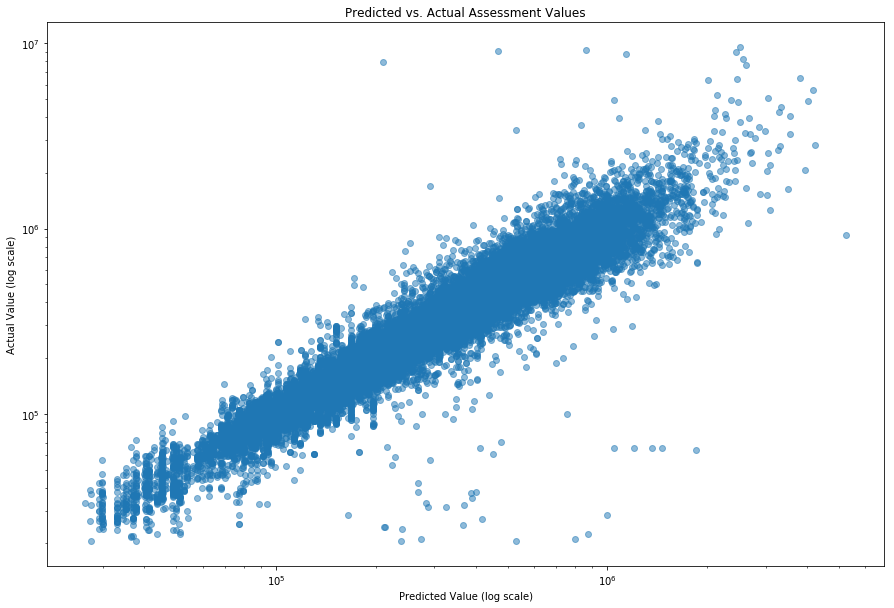

In [35]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_axis, y_axis, alpha=0.5)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [19]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
         ('rfr', RandomForestRegressor(max_depth=10, random_state=123, max_features=None))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators':(121, 150)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Create the GridSearchCV object: yeg_cv
yeg_cv_rfr = GridSearchCV(pipeline, param_grid=parameters, scoring= scoring, cv=5)

# Fit to the training set
yeg_cv_rfr.fit(X_train, y_train)

# Compute and print the metrics
mse = yeg_cv_rfr.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(yeg_cv_rfr.best_params_))
print("Tuned RandomForest Mean Squared Error: {}".format(mse))
print('Mean Error:', np.sqrt(mse))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

Tuned RandomForest estimators: {'rfr__n_estimators': 121}
Tuned RandomForest Mean Squared Error: 11965543721.80576
Mean Error: 109387.12777016206


In [20]:
joblib.dump(yeg_cv_rfr, 'RandomForest.joblib')

['RandomForest.joblib']

In [21]:
x_ax = yeg_cv_rfr.predict(X_test)
y_ax = y_test

In [22]:
import matplotlib.pyplot as plt

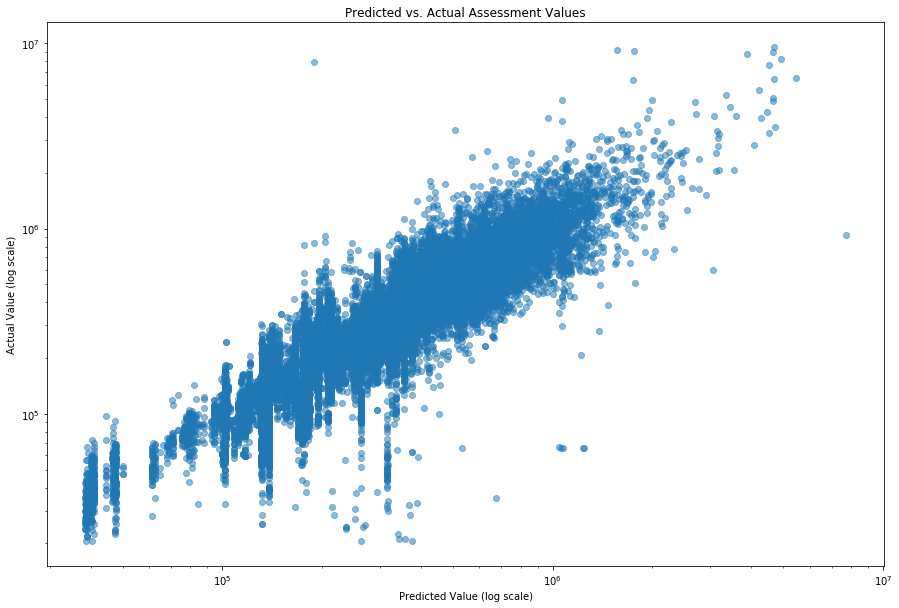

In [33]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.scatter(x_ax, y_ax, alpha=0.5)
plt.xlabel('Predicted Value (log scale)')
plt.ylabel('Actual Value (log scale)')
plt.title('Predicted vs. Actual Assessment Values')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()